***1. Изучаю датасет и немного работаю с ним***

In [1]:
import os
import urllib.request
import zipfile

def download_and_extract_camvid(dest_folder='data/CamVid'):
    os.makedirs(dest_folder, exist_ok=True)
    url = 'https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz'
    tgz_path = os.path.join(dest_folder, 'camvid.tgz')
    if not os.path.exists(tgz_path):
        print('Скачивание')
        urllib.request.urlretrieve(url, tgz_path)
    else:
        print('Уже скачан')

    import tarfile
    with tarfile.open(tgz_path) as tar:
        tar.extractall(path=dest_folder)
    print('Готово!')

download_and_extract_camvid()

Скачивание
Готово!


In [ ]:
CAMVID_CLASSES = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'SignSymbol',
    'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabelled']

CAMVID_COLORS = [
    [128, 128, 128],  # Sky
    [128, 0, 0],      # Building
    [192, 192, 128],  # Pole
    [128, 64, 128],   # Road
    [0, 0, 192],      # Pavement
    [128, 128, 0],    # Tree
    [192, 128, 128],  # SignSymbol
    [64, 64, 128],    # Fence
    [64, 0, 128],     # Car
    [64, 64, 0],      # Pedestrian
    [0, 128, 192],    # Bicyclist
    [0, 0, 0] ]       # Unlabelled

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')])
        self.masks = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')])

        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        image = T.ToTensor()(image)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

In [ ]:
import matplotlib.pyplot as plt

def decode_segmap(mask, colormap=CAMVID_COLORS):
    mask = np.array(mask)
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colormap):
        rgb[mask == i] = color
    return rgb

def show_batch(images, masks, n=4):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].cpu().numpy()
        mask_rgb = decode_segmap(mask)
        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Image')
        plt.subplot(2, n, n+i+1)
        plt.imshow(mask_rgb)
        plt.axis('off')
        plt.title('Mask')
    plt.tight_layout()
    plt.show()

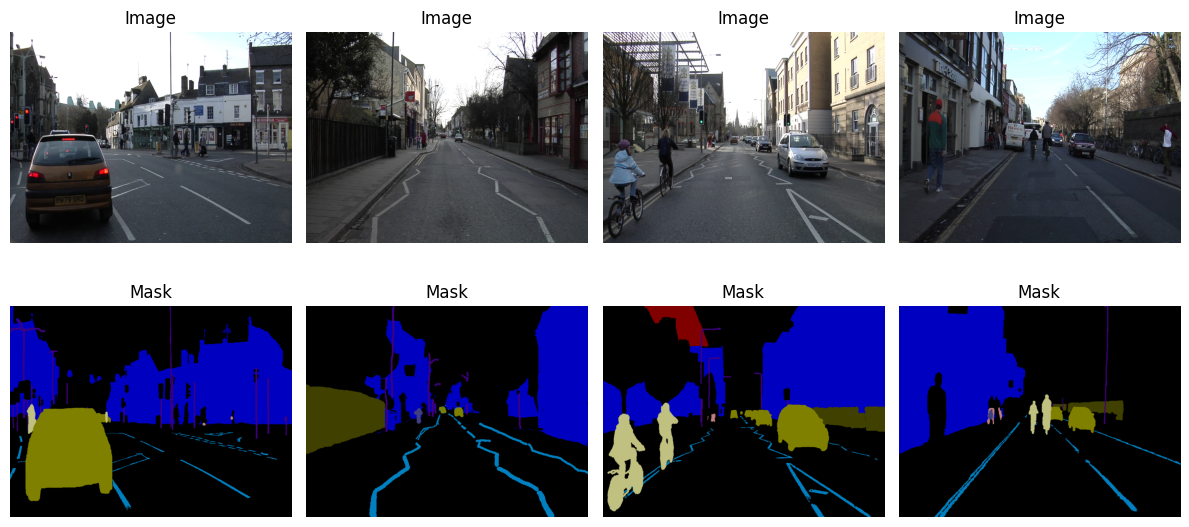

In [ ]:
from torch.utils.data import DataLoader

train_images = 'data/CamVid/camvid/images'
train_masks = 'data/CamVid/camvid/labels'
dataset = CamVidDataset(train_images, train_masks)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, masks = next(iter(dataloader))
show_batch(images, masks, n=4)

------------------------------------------------------------------------------

***Начинаю реализовывать сегментацию***

***2. U-Net модель***

In [ ]:
! pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Epoch 1/10, Loss: 1.2640


100%|██████████| 176/176 [00:37<00:00,  4.72it/s]


Epoch 2/10, Loss: 0.4671


100%|██████████| 176/176 [00:37<00:00,  4.67it/s]


Epoch 3/10, Loss: 0.3062


100%|██████████| 176/176 [00:35<00:00,  4.89it/s]


Epoch 4/10, Loss: 0.2344


100%|██████████| 176/176 [00:36<00:00,  4.80it/s]


Epoch 5/10, Loss: 0.1942


100%|██████████| 176/176 [00:36<00:00,  4.88it/s]


Epoch 6/10, Loss: 0.1571


100%|██████████| 176/176 [00:35<00:00,  4.95it/s]


Epoch 7/10, Loss: 0.1557


100%|██████████| 176/176 [00:35<00:00,  4.90it/s]


Epoch 8/10, Loss: 0.1241


100%|██████████| 176/176 [00:36<00:00,  4.80it/s]


Epoch 9/10, Loss: 0.1080


100%|██████████| 176/176 [00:35<00:00,  4.94it/s]


Epoch 10/10, Loss: 0.1024


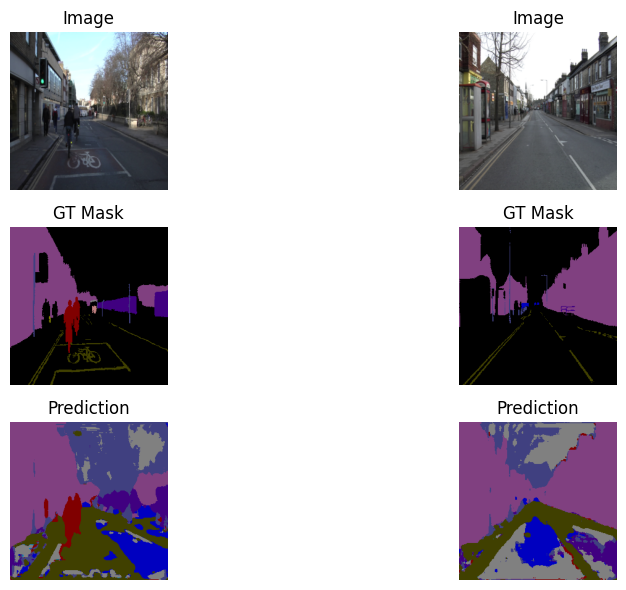

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

CAMVID_CLASSES = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'SignSymbol',
    'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabelled']

CAMVID_COLORS = [
    [128, 128, 128],
    [128, 0, 0],
    [192, 192, 128],
    [128, 64, 128],
    [0, 0, 192],
    [128, 128, 0],
    [192, 128, 128],
    [64, 64, 128],
    [64, 0, 128],
    [64, 64, 0],
    [0, 128, 192],
    [0, 0, 0] ]

def remap_mask(mask, ignore_index=255):
    mask = np.array(mask)
    mask_new = np.full_like(mask, ignore_index)
    for v in range(1, 12):
        mask_new[mask == v] = v - 1
    mask_new[mask == 255] = ignore_index
    return mask_new

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')])
        self.masks = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')])
        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        mask = remap_mask(mask, ignore_index=255)
        mask = torch.from_numpy(mask).long()
        return image, mask

train_images = 'data/CamVid/camvid/images'
train_masks = 'data/CamVid/camvid/labels'

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()])
target_transform = T.Compose([
    T.Resize((256, 256), interpolation=Image.NEAREST)])

dataset = CamVidDataset(train_images, train_masks, transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(CAMVID_CLASSES),
    activation=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = unet_model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = unet_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def decode_segmap(mask, colormap=CAMVID_COLORS):
    mask = np.array(mask)
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colormap):
        rgb[mask == i] = color
    return rgb

def show_unet_preds(model, dataloader, n=2):
    model.eval()
    images, masks = next(iter(dataloader))
    with torch.no_grad():
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        mask = masks[i].cpu().numpy()
        pred = preds[i]
        plt.subplot(3, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Image')
        plt.subplot(3, n, n+i+1)
        plt.imshow(decode_segmap(mask))
        plt.axis('off')
        plt.title('GT Mask')
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(decode_segmap(pred))
        plt.axis('off')
        plt.title('Prediction')
    plt.tight_layout()
    plt.show()

show_unet_preds(unet_model, dataloader, n=2)

In [ ]:
def compute_pixel_accuracy(preds, masks, ignore_index=255):
    valid = (masks != ignore_index)
    correct = (preds == masks) & valid
    acc = correct.sum() / valid.sum()
    return acc

def compute_iou(preds, masks, num_classes, ignore_index=255):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        valid = (masks != ignore_index)
        intersection = (pred_inds & target_inds & valid).sum()
        union = ((pred_inds | target_inds) & valid).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return ious

def evaluate_model(model, dataloader, num_classes, device, ignore_index=255):
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            all_preds.append(preds)
            all_masks.append(masks)
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    pixel_acc = compute_pixel_accuracy(all_preds, all_masks, ignore_index)
    ious = compute_iou(all_preds, all_masks, num_classes, ignore_index)
    mean_iou = np.nanmean(ious)
    return pixel_acc, ious, mean_iou

pixel_acc, ious, mean_iou = evaluate_model(unet_model, dataloader, len(CAMVID_CLASSES), device)

df = pd.DataFrame({
    "Class": CAMVID_CLASSES,
    "IoU": ious
})

df["IoU"] = df["IoU"].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
df.loc[len(df)] = ["Mean IoU", f"{mean_iou:.4f}"]
df.loc[len(df)] = ["Pixel Accuracy", f"{pixel_acc:.4f}"]

print(df.to_string(index=False))

Evaluating: 100%|██████████| 176/176 [00:28<00:00,  6.26it/s]


         Class    IoU
           Sky 0.6747
      Building 0.8870
          Pole 0.0000
          Road 0.9744
      Pavement 0.9651
          Tree 0.0000
    SignSymbol 0.0001
         Fence 0.5188
           Car 0.9059
    Pedestrian 0.9835
     Bicyclist 0.0041
    Unlabelled    N/A
      Mean IoU 0.5376
Pixel Accuracy 0.9732


-----------------------------

***3. Transformer модель***

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([12]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([12, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 351/351 [01:08<00:00,  5.12it/s]


Epoch 1/5, Loss: 0.5529


100%|██████████| 351/351 [01:05<00:00,  5.39it/s]


Epoch 2/5, Loss: 0.2279


100%|██████████| 351/351 [01:05<00:00,  5.37it/s]


Epoch 3/5, Loss: 0.1652


100%|██████████| 351/351 [01:04<00:00,  5.43it/s]


Epoch 4/5, Loss: 0.1459


100%|██████████| 351/351 [01:04<00:00,  5.43it/s]


Epoch 5/5, Loss: 0.1254


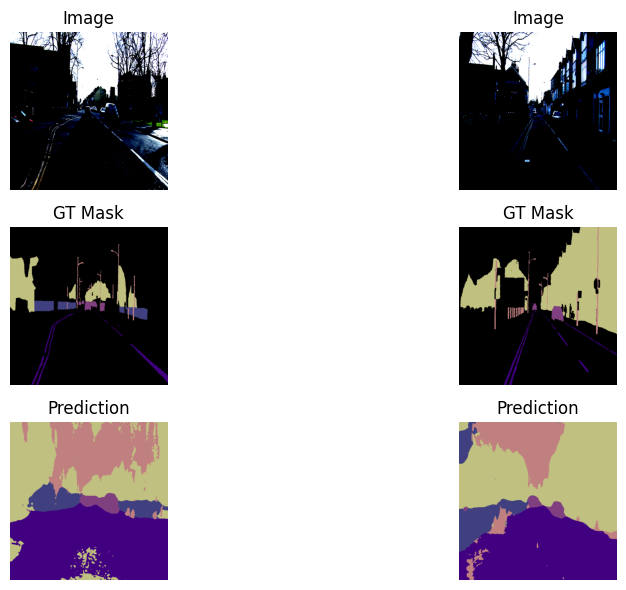

Evaluating: 100%|██████████| 351/351 [00:50<00:00,  6.97it/s]


         Class    IoU
           Sky 0.8279
      Building 0.8781
          Pole 0.9661
          Road 0.9539
      Pavement 0.0000
          Tree 0.0057
    SignSymbol 0.4278
         Fence 0.8310
           Car 0.9738
    Pedestrian 0.0000
     Bicyclist    N/A
    Unlabelled    N/A
      Mean IoU 0.5864
Pixel Accuracy 0.9666


In [ ]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

def remap_mask(mask, ignore_index=255):
    mask = np.array(mask)
    mask_new = np.full_like(mask, ignore_index)
    for v in range(1, 12):
        mask_new[mask == v] = v - 1
    mask_new[mask == 255] = ignore_index
    return mask_new

class CamVidDatasetHF(Dataset):
    def __init__(self, images_dir, masks_dir, processor, ignore_index=255):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.processor = processor
        self.ignore_index = ignore_index
        self.images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')])
        self.masks = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')])
        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        mask = remap_mask(mask, ignore_index=self.ignore_index)
        processed = self.processor(images=image, segmentation_maps=mask, return_tensors="pt")
        pixel_values = processed['pixel_values'].squeeze(0)
        labels = processed['labels'].squeeze(0)
        return pixel_values, labels

train_images = 'data/CamVid/camvid/images'
train_masks = 'data/CamVid/camvid/labels'

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=len(CAMVID_CLASSES),
    ignore_mismatched_sizes=True)

dataset_hf = CamVidDatasetHF(train_images, train_masks, processor)
dataloader_hf = DataLoader(dataset_hf, batch_size=2, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segformer_model = segformer_model.to(device)
optimizer = optim.AdamW(segformer_model.parameters(), lr=1e-4)
num_epochs = 5

for epoch in range(num_epochs):
    segformer_model.train()
    running_loss = 0.0
    for pixel_values, labels in tqdm(dataloader_hf):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = segformer_model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * pixel_values.size(0)
    epoch_loss = running_loss / len(dataset_hf)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def decode_segmap(mask, colormap=CAMVID_COLORS):
    mask = np.array(mask)
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colormap):
        rgb[mask == i] = color
    return rgb

def show_segformer_preds(model, dataloader, n=2):
    model.eval()
    pixel_values, labels = next(iter(dataloader))
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values.to(device))
        logits = outputs.logits
        logits = torch.nn.functional.interpolate(
            logits, size=labels.shape[-2:], mode='bilinear', align_corners=False
        )
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = pixel_values[i].permute(1, 2, 0).cpu().numpy()
        mask = labels[i].cpu().numpy()
        pred = preds[i]
        plt.subplot(3, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Image')
        plt.subplot(3, n, n+i+1)
        plt.imshow(decode_segmap(mask))
        plt.axis('off')
        plt.title('GT Mask')
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(decode_segmap(pred))
        plt.axis('off')
        plt.title('Prediction')
    plt.tight_layout()
    plt.show()

show_segformer_preds(segformer_model, dataloader_hf, n=2)

def compute_pixel_accuracy(preds, masks, ignore_index=255):
    valid = (masks != ignore_index)
    correct = (preds == masks) & valid
    acc = correct.sum() / valid.sum()
    return acc

def compute_iou(preds, masks, num_classes, ignore_index=255):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        valid = (masks != ignore_index)
        intersection = (pred_inds & target_inds & valid).sum()
        union = ((pred_inds | target_inds) & valid).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return ious

def evaluate_model(model, dataloader, num_classes, device, ignore_index=255):
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for pixel_values, labels in tqdm(dataloader, desc="Evaluating"):
            pixel_values = pixel_values.to(device)
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = torch.nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode='bilinear', align_corners=False
            )
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            all_preds.append(preds)
            all_masks.append(labels)
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    pixel_acc = compute_pixel_accuracy(all_preds, all_masks, ignore_index)
    ious = compute_iou(all_preds, all_masks, num_classes, ignore_index)
    mean_iou = np.nanmean(ious)
    return pixel_acc, ious, mean_iou

pixel_acc, ious, mean_iou = evaluate_model(segformer_model, dataloader_hf, len(CAMVID_CLASSES), device)

df = pd.DataFrame({
    "Class": CAMVID_CLASSES,
    "IoU": ious})

df["IoU"] = df["IoU"].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
df.loc[len(df)] = ["Mean IoU", f"{mean_iou:.4f}"]
df.loc[len(df)] = ["Pixel Accuracy", f"{pixel_acc:.4f}"]

print(df.to_string(index=False))

------------------------------------------------

***Смотрю кол-во параметров и время на обучение моделей***

In [ ]:
import time

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(CAMVID_CLASSES),
    activation=None)

unet_model = unet_model.to(device)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
num_epochs = 5

for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = unet_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

end_time = time.time()
peak_memory = torch.cuda.max_memory_allocated() / 1024**3

print(f"\nU-Net:")
print(f"Время обучения: {(end_time - start_time):.2f} секунд")
print(f"Пиковое потребление GPU-памяти: {peak_memory:.2f} ГБ")
print(f"Параметров в модели: {count_params(unet_model):,}")

100%|██████████| 176/176 [00:36<00:00,  4.88it/s]


Epoch 1/5, Loss: 1.2644


100%|██████████| 176/176 [00:35<00:00,  4.99it/s]


Epoch 2/5, Loss: 0.4405


100%|██████████| 176/176 [00:36<00:00,  4.80it/s]


Epoch 3/5, Loss: 0.2683


100%|██████████| 176/176 [00:35<00:00,  4.99it/s]


Epoch 4/5, Loss: 0.2023


100%|██████████| 176/176 [00:35<00:00,  4.90it/s]

Epoch 5/5, Loss: 0.1720

U-Net:
Время обучения: 179.83 секунд
Пиковое потребление GPU-памяти: 1.04 ГБ
Параметров в модели: 24,437,964


In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=len(CAMVID_CLASSES), ignore_mismatched_sizes=True)

segformer_model = segformer_model.to(device)
optimizer = optim.AdamW(segformer_model.parameters(), lr=1e-4)
num_epochs = 5

for epoch in range(num_epochs):
    segformer_model.train()
    running_loss = 0.0
    for pixel_values, labels in tqdm(dataloader_hf):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = segformer_model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * pixel_values.size(0)
    epoch_loss = running_loss / len(dataset_hf)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

end_time = time.time()
peak_memory = torch.cuda.max_memory_allocated() / 1024**3

print(f"\nSegFormer:")
print(f"Время обучения: {(end_time - start_time):.2f} секунд")
print(f"Пиковое потребление GPU-памяти: {peak_memory:.2f} ГБ")
print(f"Параметров в модели: {count_params(segformer_model):,}")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([12]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([12, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 351/351 [01:05<00:00,  5.40it/s]


Epoch 1/5, Loss: 0.5262


100%|██████████| 351/351 [01:05<00:00,  5.37it/s]


Epoch 2/5, Loss: 0.2256


100%|██████████| 351/351 [01:05<00:00,  5.38it/s]


Epoch 3/5, Loss: 0.1634


100%|██████████| 351/351 [01:20<00:00,  4.34it/s]


Epoch 4/5, Loss: 0.1356


100%|██████████| 351/351 [01:12<00:00,  4.83it/s]

Epoch 5/5, Loss: 0.1173

SegFormer:
Время обучения: 350.46 секунд
Пиковое потребление GPU-памяти: 1.43 ГБ
Параметров в модели: 3,717,228


- Если говорить про выигрыш трансформера, то мы имеем кол-во параметров, которое более, чем в 7 раз меньше U-Net(а).

-------------------------------------------------------